# Integrator probing

Including the bar can sometimes cause orbits to not be reverse integratable. I will modify integrator.f90 to print the intermediate accelerations so that they can be checked 


In [1]:
import tstrippy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt
import datetime
import bar_sensitivity_integration_timestep_and_time as bsitt

In [2]:
def backward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar):
    nObj = 1 # only integrating one object
    currenttime,dt,Ntimestep=integrationparameters
    MWname, MWparams = staticgalaxy
    x0,y0,z0,vx0,vy0,vz0 = initialkinematics
    barname,barparams,barpolycoeff = galacticbar

    tstrippy.integrator.setstaticgalaxy(MWname,MWparams)
    tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
    tstrippy.integrator.setinitialkinematics(x0,y0,z0,vx0,vy0,vz0)
    tstrippy.integrator.setbackwardorbit()
    tstrippy.integrator.setdebugaccelerations()
    tstrippy.integrator.initgalacticbar(barname,barparams,barpolycoeff)
    starttime = datetime.datetime.now()
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward=tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    endtime=datetime.datetime.now()
    abar = tstrippy.integrator.abar.copy()
    tstrippy.integrator.deallocate()
    orbit = [xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward]
    accelerations = [abar]
    return orbit, accelerations


In [3]:
def forward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar):
    nObj = 1 # only integrating one object
    currenttime,dt,Ntimestep=integrationparameters
    MWname, MWparams = staticgalaxy
    x0,y0,z0,vx0,vy0,vz0 = initialkinematics
    barname,barparams,barpolycoeff = galacticbar
    tstrippy.integrator.setstaticgalaxy(MWname,MWparams)
    tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
    tstrippy.integrator.setinitialkinematics(x0,y0,z0,vx0,vy0,vz0)
    tstrippy.integrator.setdebugaccelerations()
    tstrippy.integrator.initgalacticbar(barname,barparams,barpolycoeff)
    starttime = datetime.datetime.now()
    xForward,yForward,zForward,vxForward,vyForward,vzForward=tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    aBAR = tstrippy.integrator.abar.copy()
    endtime=datetime.datetime.now()
    tstrippy.integrator.deallocate()
    orbit = [xForward,yForward,zForward,vxForward,vyForward,vzForward]
    accelerations = [aBAR]
    return orbit, accelerations


In [4]:
def backward_and_forward_orbit(integrationtime,timestep,staticgalaxy,initialkinematics,galacticbar):
    

    assert integrationtime > 0
    assert timestep > 0
    assert isinstance(integrationtime, (int, float))
    assert isinstance(timestep, (int, float))
    unitT, unitV, unitD, unitM, unitG, G = bsitt.loadunits()

    # convert to integration units
    Ntimestep=int(integrationtime/timestep)
    T,dt=integrationtime*u.yr,timestep*u.yr
    T,dt=T.to(unitT),dt.to(unitT)
    # make sure the current time is set to today for backward integration
    currenttime = 0*unitT
    integrationparameters = [currenttime,dt,Ntimestep]
    backorbit,backcaccel = \
        backward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar)
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward = backorbit
    # extract the final conditions for the forward integration
    xf,yf,zf,vxf,vyf,vzf = xBackward[0][-1],yBackward[0][-1],zBackward[0][-1],-vxBackward[0][-1],-vyBackward[0][-1],-vzBackward[0][-1]
    # set the initial time 
    currenttime = -T
    initialkinematics = [xf,yf,zf,vxf,vyf,vzf]
    integrationparameters = [currenttime,dt,Ntimestep]
    fordwardorbit,forwardaccel = \
        forward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar)
    xForward,yForward,zForward,vxForward,vyForward,vzForward = fordwardorbit
    backwardorbit = [xBackward[0],yBackward[0],zBackward[0],-vxBackward[0],-vyBackward[0],-vzBackward[0]]
    forwardorbit = [xForward[0],yForward[0],zForward[0],vxForward[0],vyForward[0],vzForward[0]]
    
    return backwardorbit, forwardorbit, backcaccel, forwardaccel

In [5]:
targetGC = "NGC5139"
# load units
unitT, unitV, unitD, unitM, unitG, G=bsitt.loadunits()
# Load the galaxy parameters
MWparams, MWrefframe = bsitt.loadGalaxy()
# Load the bar parameters
barparams = bsitt.barparams_ferrone2023()
# Load the bar movement
barpolycoeff = bsitt.bar_movement_ferrone2023()
# Reduce the mass of the disks to account for the bar
MWparams[5] = 1120.0 * 2.32*10**7 
MWparams[8] = 1190.0 * 2.32*10**7 
# Extract the initial conditions of the target globular cluster
x0,y0,z0,vx0,vy0,vz0 = bsitt.pick_globular_cluster(targetGC, MWrefframe)

In [6]:
#### Begin storing the input data for the integrator
Galaxy = ["pouliasis2017pii", MWparams]
bar = ["longmuralibar", barparams, barpolycoeff]
initialkinematics = [x0,y0,z0,vx0,vy0,vz0]

In [49]:
integrationtime = 1.5e8
timestep = 1e6

In [50]:
backwardorbit, forwardorbit, backcaccel, forwardaccel=backward_and_forward_orbit(integrationtime,timestep,Galaxy,initialkinematics,bar)

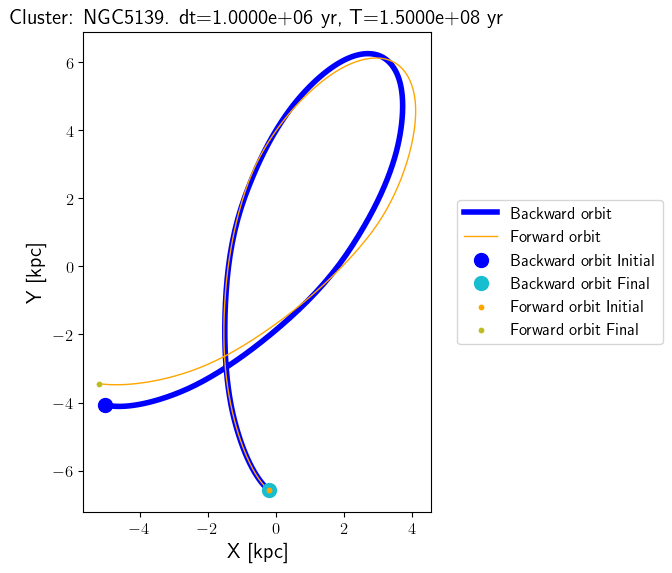

In [51]:
plotdata0={"x":backwardorbit[0],"y":backwardorbit[1]}
plotdata1={"x":forwardorbit[0],"y":forwardorbit[1]}
title="Cluster: {}. dt={:.4e} yr, T={:.4e} yr".format(targetGC,timestep,integrationtime)
axisconfig={'xlabel':"X [kpc]",'ylabel':"Y [kpc]",'aspect':'equal','title':title}
pltobj0={"label":"Backward orbit","color":"blue"}
pltobj1={"label":"Forward orbit","color":"orange"}
fig,axis=bsitt.plot_orbits([plotdata0,plotdata1],[pltobj0,pltobj1],axisconfig)

In [55]:
x_back = backwardorbit[0]
x_forward = np.flip(forwardorbit[0])
timearray = np.linspace(-integrationtime,0,len(x_back))
xmin = min(x_back)
xmax = max(x_back)

Text(0, 0.5, 'Forward X [kpc]')

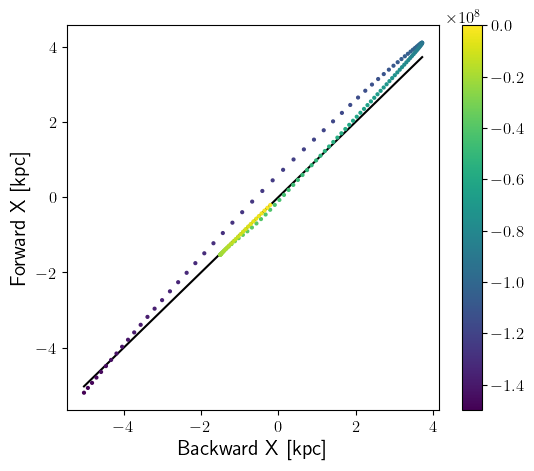

In [59]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
im=axis.scatter(x_back,x_forward,c=timearray,cmap='viridis',s=4)
cbar = plt.colorbar(im, ax=axis)
axis.plot([xmin,xmax],[xmin,xmax],color='black',linestyle='-',zorder=0)
axis.set_xlabel("Backward X [kpc]")
axis.set_ylabel("Forward X [kpc]")